In [27]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
%matplotlib inline

In [13]:
#используется тот же датасет что и на прошлых домашках 
dementia = pd.read_csv('dementia_dataset+(1) (1).csv')
dementia.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [14]:
dementia.rename(columns={'Group':'Dementia'}, inplace=True)
X = dementia.drop(columns=['Subject ID', 'MRI ID', 'Dementia'])
y = dementia['Dementia']
X_train, X_test, y_train, y_test = train_test_split(dementia.drop(columns=['Subject ID', 'MRI ID', 'Dementia']), 
                                                                  dementia['Dementia'], test_size=.2, random_state=42)

categorical = list(X_train[['M/F', 'Hand','Visit', 'SES']])
print(f'Categorical columns are: {categorical}')

numerical = list(X_train[['MR Delay', 'Age', 'EDUC', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']])
print(f'Numerical columns are: {numerical}')

Categorical columns are: ['M/F', 'Hand', 'Visit', 'SES']
Numerical columns are: ['MR Delay', 'Age', 'EDUC', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']


In [16]:
y_train = y_train.apply(lambda x: 1 if x != "Nondemented" else 0)
y_test = y_test.apply(lambda x: 1 if x != "Nondemented" else 0)

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('onehotencoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat2', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

In [17]:
def model_in_pipeline(model, preprocessor, x, y):
    myModel = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    myModel.fit(x, y)
    print(f"Качество классификации модели: {myModel.score(x,y):.2f}")

In [18]:
rf = RandomForestClassifier()
logreg = LogisticRegression()
print('Cлучайный лес на тренировочной выборке')
model_in_pipeline(rf, preprocessor, X_train, y_train)
print('Cлучайный лес на тестовой выборке')
model_in_pipeline(rf, preprocessor, X_test, y_test)
print()
print('Логрег на тренировочной выборке')
model_in_pipeline(logreg, preprocessor, X_train, y_train)
print('Логрег на тестовой выборке')
model_in_pipeline(logreg, preprocessor, X_test, y_test)

#модель сама справилась на ура даже без тюнинга параметров
#но посмотрим дальше важность фич и применит бустинг 

Cлучайный лес на тренировочной выборке
Качество классификации модели: 1.00
Cлучайный лес на тестовой выборке
Качество классификации модели: 1.00

Логрег на тренировочной выборке
Качество классификации модели: 0.96
Логрег на тестовой выборке
Качество классификации модели: 0.87


In [19]:
rf.feature_importances_

In [23]:
X = preprocessor.fit_transform(X, y)

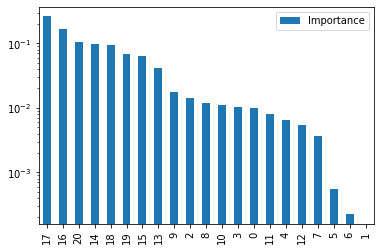

In [25]:
#а решающие деревья здесь всё-таки очень хороши 
#посмотрим на значимость признаков 
#пока мы энкодили наши признаки пропали названия колонок, так что мы пока видим что какая-то фича просто оказалась важнее
X = pd.DataFrame(X)

feat_import = pd.DataFrame(data = rf.feature_importances_, index = X.columns, columns=['Importance'])
feat_import = feat_import.sort_values(by = 'Importance', ascending = False)
feat_import.head(30).plot(kind='bar', logy=True)

In [29]:
#теперь поработает с бустингом 
#подберём сначала для него оптимальные гиперпараметры 

xgb_clf = XGBClassifier()
param_grid = {
    'max_depth': [10, 15, 20], 
    'min_child_weight': [1, 3],
    'n_estimators': [50, 70],
    'learning_rate': [0.5, 0.7]
}

grid = GridSearchCV(xgb_clf, param_grid=param_grid, cv = 3, verbose=5, n_jobs=-1)
model_in_pipeline(grid, preprocessor, X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[22:40:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Качество классификации модели: 1.00


/opt/python/envs/default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [32]:
test_model = model_in_pipeline(grid, preprocessor, X_test, y_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [34]:
print("Лучшие параметры:\n{}\n".format(grid.best_params_))
print("Лучший скор: {:.2f}".format(grid.best_score_))
print("Скор на тестовой выборке: {:.2f}".format(grid.score(X_test, y_test)))

Лучшие параметры:
{'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 50}

Лучший скор: 0.85


ValueError: ValueError: Feature shape mismatch, expected: 21, got 12